In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans

In [6]:
final_tourist_data = pd.read_csv('final_final_tourist_data.csv')
tourist_data_with_ratings = pd.read_csv('tourist_data_with_ratings.csv')

In [7]:
df = final_tourist_data.merge(tourist_data_with_ratings, left_on='Name', right_on='Attraction', how='inner')


In [8]:
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

In [9]:
df['Tags'] = df['Tags'].fillna('')

In [10]:
vectorizer = TfidfVectorizer(stop_words='english')
tags_matrix = vectorizer.fit_transform(df['Tags'])

In [11]:
scaler = MinMaxScaler()
df[['Rating', 'Latitude', 'Longitude']] = scaler.fit_transform(df[['Rating', 'Latitude', 'Longitude']])

In [12]:
content_matrix = hstack([tags_matrix, csr_matrix(df[['Rating', 'Latitude', 'Longitude']].values)])

In [13]:
tourist_data_with_ratings = tourist_data_with_ratings.groupby(['User_ID', 'Attraction']).agg({'User_Rating': 'mean'}).reset_index()
user_item_matrix = tourist_data_with_ratings.pivot(index='User_ID', columns='Attraction', values='User_Rating').fillna(0).values
user_item_matrix = csr_matrix(user_item_matrix)

In [14]:
n_components = 20  
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_item_reduced = svd.fit_transform(user_item_matrix)


In [15]:
user_item_approx_reduced_expanded = np.tile(user_item_reduced, (int(np.ceil(content_matrix.shape[0] / user_item_reduced.shape[0])), 1))
user_item_approx_reduced_expanded = user_item_approx_reduced_expanded[:content_matrix.shape[0], :]

In [16]:
user_item_approx_reduced_expanded_sparse = csr_matrix(user_item_approx_reduced_expanded)

In [17]:
kmeans = KMeans(n_clusters=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(tags_matrix)

C:\Users\Mohib\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
cluster_features = pd.get_dummies(df['Cluster'])
cluster_matrix = csr_matrix(cluster_features.values)

In [19]:
weight_content = 0.6
weight_collaborative = 0.3
weight_cluster = 0.1
hybrid_matrix = hstack([
    weight_content * content_matrix, 
    weight_collaborative * user_item_approx_reduced_expanded_sparse, 
    weight_cluster * cluster_matrix
])


In [20]:
y = df['User_Rating']

X = hybrid_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

rmse_hybrid = np.sqrt(mean_squared_error(y_test, y_pred))
mae_hybrid = mean_absolute_error(y_test, y_pred)
r2_hybrid = r2_score(y_test, y_pred)

print(f"Weighted Hybrid Model with KMeans Clustering - RMSE: {rmse_hybrid:.4f}")
print(f"Weighted Hybrid Model with KMeans Clustering - MAE: {mae_hybrid:.4f}")
print(f"Weighted Hybrid Model with KMeans Clustering - R^2 Score: {r2_hybrid:.4f}")


Weighted Hybrid Model with KMeans Clustering - RMSE: 0.9480
Weighted Hybrid Model with KMeans Clustering - MAE: 0.7760
Weighted Hybrid Model with KMeans Clustering - R^2 Score: -0.0043


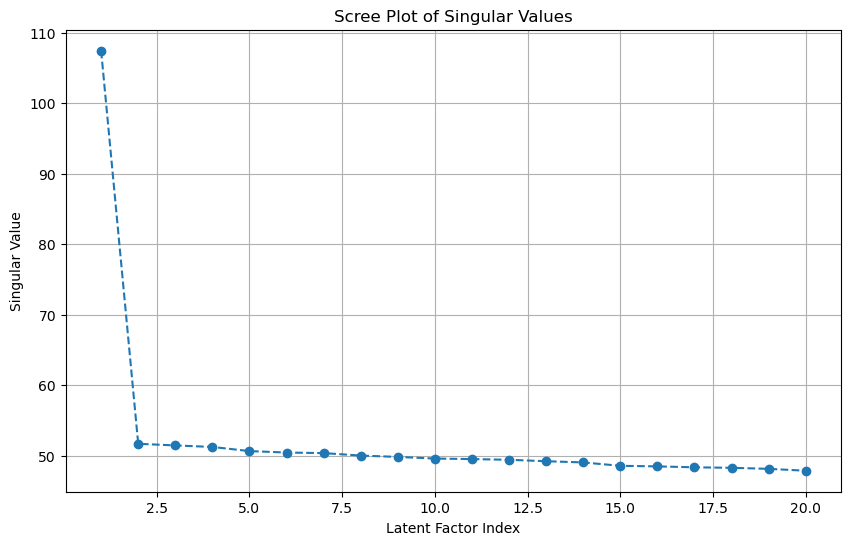

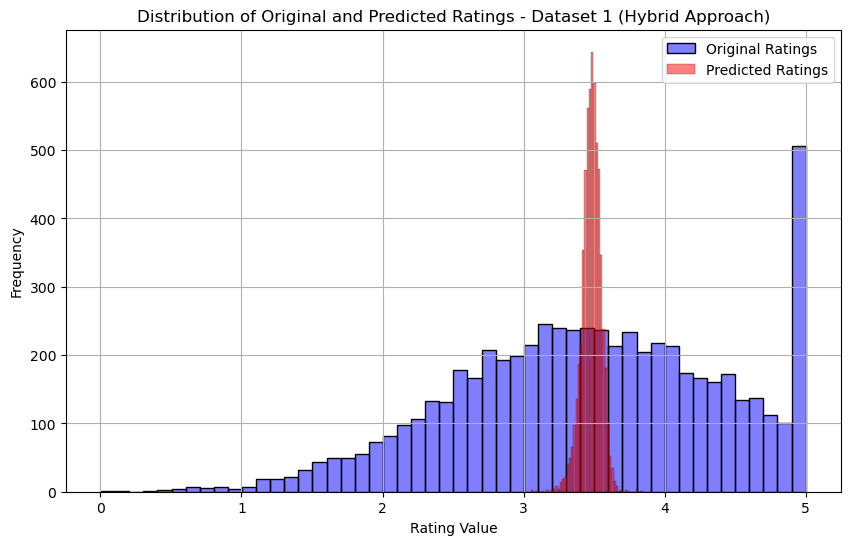

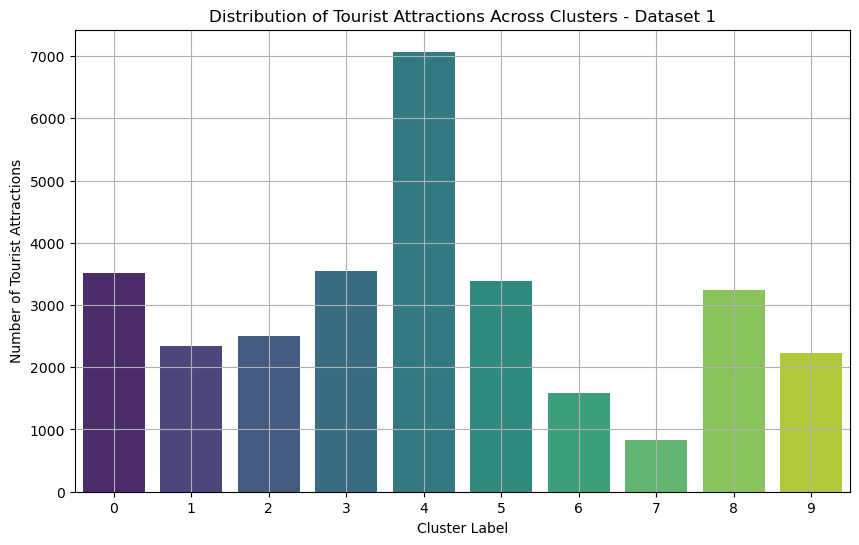

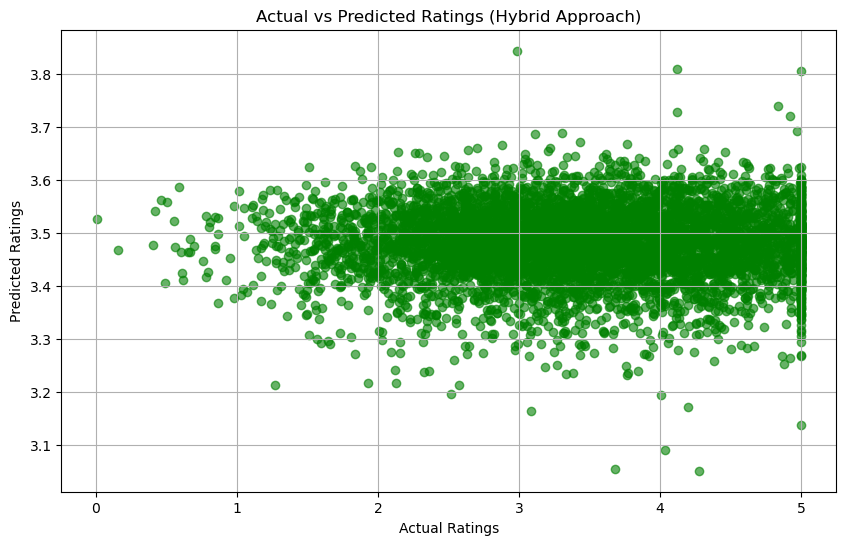

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), svd.singular_values_, marker='o', linestyle='--')
plt.xlabel('Latent Factor Index')
plt.ylabel('Singular Value')
plt.title('Scree Plot of Singular Values')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=50, color='blue', alpha=0.5, label='Original Ratings')
sns.histplot(y_pred, bins=50, color='red', alpha=0.5, label='Predicted Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Frequency')
plt.title('Distribution of Original and Predicted Ratings - Dataset 1 (Hybrid Approach)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=df, palette='viridis')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Tourist Attractions')
plt.title('Distribution of Tourist Attractions Across Clusters - Dataset 1')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings (Hybrid Approach)')
plt.grid(True)
plt.show()


In [49]:
def generate_recommendations(user_id, ridge_model, hybrid_matrix, df, top_n=5):
    
    user_index = user_id - 1 
    user_features = hybrid_matrix[user_index].toarray()

    attraction_features = hybrid_matrix.toarray()  # All attraction features
    predicted_ratings = ridge_model.predict(attraction_features)

    recommendations = pd.DataFrame({
        'Attraction': df['Name'].values,

    })

    recommendations = recommendations.drop_duplicates(subset='Attraction', keep='first')

    return recommendations.head(top_n)


In [50]:

print(f"Hybrid Matrix Shape: {hybrid_matrix.shape}")
print(f"Number of Attractions in df: {len(df['Name'])}")

user_id = 1
top_n = 5

try:
    top_recommendations = generate_recommendations(user_id, ridge_model, hybrid_matrix, df, top_n)

    print(f"Top {top_n} recommendations for User {user_id} - Dataset 1:")
    print(top_recommendations)
except ValueError as e:
    print(f"Error: {e}")


Hybrid Matrix Shape: (30266, 169)
Number of Attractions in df: 30266
Top 5 recommendations for User 1 - Dataset 1:
                                     Attraction
0                          Hungry Boba Pizzeria
7                  A Rural Experience Day Tours
16           Teach an Tae Aran Café & Tea Rooms
20                A Heritage Walk of Old Galway
23  A Spasso A Dublino - Italian Tour in Dublin


In [43]:
print(df['Name'].value_counts().head(10))

Inishkea Islands            34
The Old Stand               26
Midlands Angling            20
Michael J Quill Centre      20
Marble Hill                 20
Stena Line                  18
Spanish Point               16
Royal Cork Yacht Club       16
Into the West Adventures    14
ATC Language & Travel       12
Name: Name, dtype: int64
